In [1]:
#import utils.custom_nn as cn
import utils.ansatz as astz
import utils.feature_map as fm
import utils.data_processing as dp
from utils.noise_models import qe_noise_model, th_noise_model, ro_noise_model
from utils.backends import qw_contralto, ibm_5q, ibm_127q, aer_sv, aer_dm, aer_mps

import pandas as pd

import torch
import torch.nn as nn
import torchmetrics

from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


/Users/stefan.kister/opt/virtual/quiskit_v10x/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import warnings

# ignore off UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

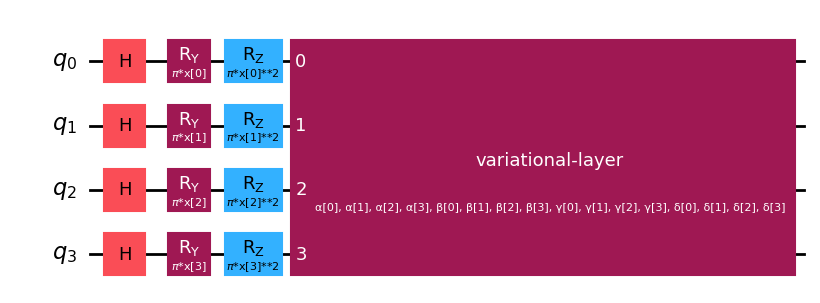

In [11]:
# Data parameters:
DATA_PATH = "data/data_damped_oscillator.csv"
# DATA_PATH = "data/custom_created_pattern.csv"
TIME_SEQUENCE = 4

# Model parameters:
INPUT_SIZE = 1 # the input feature dimension, in our case with functions always 1
HIDDEN_SIZE = 1 #dimension of the hidden state, represents the size or dimensionality of the hidden state in the LSTM

# Training parameters:
TRAIN_TEST_SPLIT = 0.67
NUM_EPOCHS = 5
BATCH_SIZE = 10
LEARNING_RATE = 0.01

# Quantum backend definitions
#noise_model = ro_noise_model(0.05, 0.05)
noise_model = False
backend = aer_sv()



TEST_RUNS = 1

# Quantum Circuits
num_qubits = 4
FEATURE_MAP = fm.FeatureMap_4(num_qubits)
ANSATZ = astz.VariationalLayer_4(num_qubits)


REPS = 1

VQC_var = QuantumCircuit(num_qubits)
for i in range(REPS):
                VQC_var.append(ANSATZ, range(num_qubits))

VQC = FEATURE_MAP.compose(VQC_var)
VQC.draw('mpl')

In [12]:
class QuantumLongShortTermMemory(nn.Module):
    def __init__(self, vqc, num_qubits, feature_map, ansatz, input_size: int=4, hidden_size: int=1, seed: int=1):
        super().__init__()

        self.input_sz = input_size
        self.hidden_sz = hidden_size
        self.seed = seed

        # construct quantum layer
        self.VQC = nn.ModuleDict() # WICHTIG to connect 
        self.construct_VQC_layer(vqc, num_qubits, feature_map, ansatz)

        # classical layer
        self.input_layer = nn.Linear(self.input_sz + self.hidden_sz, self.input_sz)
        self.input_layer_2 = nn.Linear(1, self.input_sz)


    def construct_VQC_layer(self, vqc, num_qubits, feature_map, ansatz):
        # construct the 4 QNN layer
        for layer_name in ["1", "2", "3", "4", "5"]:
            # initialize the QNN layer
            obsv = SparsePauliOp(["Z"*num_qubits]) 
            estimator = Estimator(backend=backend, options={'NoiseModel': noise_model})
            qnn = EstimatorQNN(
                    circuit=vqc,
                    estimator=estimator,
                    observables=obsv,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    input_gradients=True
            )

            # WICHTIG connector
            self.VQC[layer_name] = TorchConnector(qnn)


    def forward(self, X: torch.Tensor, memory_states: tuple = None):
        if memory_states is None:
            # initialize memory states
            h_t, c_t = (torch.zeros(1, self.hidden_sz).to(X.device), 
                        torch.zeros(1, self.hidden_sz).to(X.device))
        else:
            h_t, c_t = memory_states 

        outputs = []
        for sample_x in X: 
            v_t = torch.cat([sample_x, h_t], dim=0)
            v_t_input = self.input_layer(v_t.reshape(1, -1)).reshape(-1)
            # QNN layer
            f_t = torch.sigmoid(self.VQC["1"](v_t_input))
            i_t = torch.sigmoid(self.VQC["2"](v_t_input))
            c_tilde = torch.tanh(self.VQC["3"](v_t_input))
            c_t = f_t * c_t + i_t * c_tilde
            o_t = torch.sigmoid(self.VQC["4"](v_t_input))
            h_t = self.VQC["5"]((self.input_layer_2(o_t * torch.tanh(c_t))))
            outputs.append(h_t.unsqueeze(0))
        
        outputs = torch.cat(outputs, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        outputs = outputs.transpose(0, 1).contiguous()

        return outputs, (h_t, c_t)

In [13]:
# load the data
data = pd.read_csv(DATA_PATH, usecols=["y"])

# preprocess and split data - data_processing() from data_processing.py
input_train, target_train, input_test, target_test = dp.data_processing(data, time_sequence=TIME_SEQUENCE, train_test_split=TRAIN_TEST_SPLIT, reshape_inputs=True)

# create a TensorDataset from input and target tensors
train_dataset = torch.utils.data.TensorDataset(input_train, target_train)

# create a DataLoader for efficient batch processing
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# generator and worker_init_fn is used to assure reproducibility (https://pytorch.org/docs/stable/notes/randomness.html Section: DataLoader)


# reshape the the target(_test & _train) tensor [len, 1, 1] - to match the shape of the pred tensor [len, 1]
target_test_reshape = target_test.reshape(len(target_test), 1)
target_train_reshape = target_train.reshape(len(target_train), 1)

All shapes are correct.


In [ ]:
# initialize the model
q_lstm = QuantumLongShortTermMemory(vqc=VQC, num_qubits=num_qubits, feature_map=FEATURE_MAP, ansatz=ANSATZ)

# initialize the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(q_lstm.parameters(), lr=LEARNING_RATE)

# set the model to training mode
q_lstm.train() 

# training loop
losses = []

# get the number of batches to process
if len(train_dataset) % BATCH_SIZE == 0:
    num_batches = len(train_dataset) // BATCH_SIZE
else:
    num_batches = len(train_dataset) // BATCH_SIZE + 1

for epoch in range(NUM_EPOCHS):
    # clear gradients them out before each instance
    q_lstm.zero_grad()

    running_loss = 0.0
    batch_num = 1
    for batch_input, batch_target in data_loader:
        print(f"\rEpoch [{epoch+1}/{NUM_EPOCHS}]: Batch Number [{batch_num}/{num_batches}]", end="", flush=True)
        batch_num += 1
        # zero the gradients
        optimizer.zero_grad()
        # forward pass
        outputs , (_, _) = q_lstm(batch_input)

        # compute the loss
        loss = loss_function(outputs.reshape(len(batch_input), 1), batch_target.reshape(len(batch_target), 1))

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # accumulate the loss
        running_loss += loss.item()
    
    # compute the average loss for the epoch
    epoch_loss = running_loss / len(data_loader)

    # save loss for plotting
    losses.append(epoch_loss)

    # Print the loss for the epoch
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]; Loss: {epoch_loss:.6f}\n")

Epoch [1/5]: Batch Number [1/20]